# Yape architecture simulation: monolith vs. cell-based write-path

This notebook orchestrates a discrete-event simulation (DES) comparing a
synchronous monolithic write-path against an asynchronous, sharded cell-based
ingestion pattern under configurable traffic conditions.

**Outputs:** publication-ready figures (PNG, 300 dpi) and summary-statistics
tables suitable for direct inclusion in an academic manuscript.

**Reproducibility:** all experiment parameters are defined in a single
`ExperimentConfig` dataclass — no tunable values are hard-coded in the
simulation engine.  The random seed guarantees bitwise-identical results
across environments.

**Author:** Carlos Ulisses Flores  
**License:** Apache 2.0  

**Repository:** [mit507-yape-architecture-sim](https://github.com/ulissesflores/mit507-yape-architecture-sim)


## 1 &ensp; Environment bootstrap

Clone the repository (if running on Colab) and install **only** the packages
that Colab does not ship (currently just `simpy`).  The scientific stack
(`numpy`, `pandas`, `matplotlib`, `seaborn`) is left untouched to avoid
ABI-incompatible binary reinstallation — the root cause of the
`numpy.dtype size changed` crash on Colab kernels.

For local execution, `pip install -r requirements.txt` installs exact pins.


In [1]:
"""Environment bootstrap — Colab-safe, no kernel restart required."""

from __future__ import annotations

import subprocess
import sys
from pathlib import Path


REPO_URL: str = "https://github.com/ulissesflores/mit507-yape-architecture-sim.git"
REPO_DIR: Path = Path("mit507-yape-architecture-sim")


def _is_colab() -> bool:
    try:
        import google.colab  # type: ignore[import-untyped]  # noqa: F401
        return True
    except Exception:
        return False


def _find_project_root(start: Path) -> Path | None:
    """Walk upward until a directory containing src/simulation.py is found."""
    for p in [start, *start.parents]:
        if (p / "src" / "simulation.py").exists():
            return p
    return None


def bootstrap() -> Path:
    """Resolve project root, install only missing packages, return root path.

    Design rationale
    ----------------
    Colab ships pre-compiled numpy >= 2.x, pandas, matplotlib, and seaborn.
    Force-reinstalling older pinned versions (e.g. numpy 1.26.4) over live
    Cython extensions causes an irrecoverable ABI mismatch:
        ``ValueError: numpy.dtype size changed``

    This bootstrap therefore installs **only** packages absent from the
    runtime (currently ``simpy``).  No kernel restart is triggered.

    For fully pinned local reproducibility, use:
        ``pip install -r requirements.txt``
    """
    # 1) Resolve or clone the project.
    root = _find_project_root(Path.cwd())
    if root is None:
        if not REPO_DIR.exists():
            print(f"Cloning {REPO_URL} ...")
            subprocess.run(
                ["git", "clone", "--depth", "1", REPO_URL, str(REPO_DIR)],
                check=True,
            )
        root = REPO_DIR.resolve()

    # 2) Ensure src/ is an importable package.
    src_dir = root / "src"
    src_dir.mkdir(parents=True, exist_ok=True)
    (src_dir / "__init__.py").touch(exist_ok=True)

    # 3) Install only packages that are missing (never force-reinstall).
    missing: list[str] = []
    try:
        import simpy  # noqa: F401
    except ImportError:
        missing.append("simpy")

    if missing:
        print(f"Installing missing packages: {missing}")
        subprocess.run(
            [sys.executable, "-m", "pip", "install", "--quiet", *missing],
            check=True,
        )

    # 4) Add project root to sys.path.
    if str(root) not in sys.path:
        sys.path.insert(0, str(root))

    print(f"Project root: {root}")
    return root


PROJECT_ROOT = bootstrap()


Cloning https://github.com/ulissesflores/mit507-yape-architecture-sim.git ...
Installing missing packages: ['simpy']
Project root: /content/mit507-yape-architecture-sim


## 2 &ensp; Imports and plot configuration


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from src.simulation import ExperimentConfig, run_simulation

# Publication-quality plot defaults.
sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update(
    {
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "axes.titlesize": 12,
        "figure.titlesize": 14,
    }
)

print(
    f"numpy {np.__version__}  |  pandas {pd.__version__}  |  "
    f"ExperimentConfig fields: {len(ExperimentConfig.__dataclass_fields__)}"
)


numpy 2.0.2  |  pandas 2.2.2  |  ExperimentConfig fields: 15


## 3 &ensp; Experiment configuration

All tunable parameters are declared here — **not** inside the simulation
engine.  This separation follows the configuration-as-data principle:
changing experimental conditions never requires modifying source code.

The `ExperimentConfig` dataclass is frozen (immutable) and validates
invariants at construction time.


In [3]:
# --------------------------------------------------------------------------
# Experiment parameters (edit ONLY this cell to vary conditions)
# --------------------------------------------------------------------------

# Aggregation window used for throughput (Fig. 4).
THROUGHPUT_BIN_MS = 500  # ms

SHARED_PARAMS = dict(
    random_seed=42,
    simulation_time=30_000,          # horizon (ms)
    arrival_rate_normal=50,          # transactions / second
    arrival_rate_stress=2000,        # transactions / second
    event_bus_ack_ms=2.0,            # baseline async ingress ACK (ms)
    num_cells=10,                    # cell-based shards
    db_pool_capacity=50,             # monolith connection-pool slots
    cell_capacity=10,                # per-cell worker capacity
    contention_queue_threshold=20,   # monolith degradation trigger
    contention_penalty_factor=5.0,   # service-time multiplier
    latency_log_mean_ms=50.0,        # log-normal location (ms)
    latency_log_sigma=0.5,           # log-normal scale
    shard_id_upper_bound=10_000,     # uniform shard-key space
)

# ACK variability model (CELL_BASED only).
# These parameters are explicitly designed to be:
# (i) lightweight (no extra dependencies),
# (ii) reproducible (seeded RNG),
# (iii) empirically plausible (micro-jitter + rare tail spikes),
# (iv) configurable from this notebook cell (no hard-coded magic numbers).
ACK_JITTER_PARAMS = dict(
    event_bus_ack_jitter_lognorm_sigma=0.25,   # multiplicative jitter (mean 1.0)
    event_bus_ack_additive_std_ms=0.30,        # additive micro-jitter (ms)
    event_bus_ack_backlog_scale_ms=0.01,       # backlog sensitivity (ms per queued req)
    event_bus_ack_tail_prob=0.003,             # rare tail event probability
    event_bus_ack_tail_lognorm_mu=float(np.log(30.0)),  # tail spike μ (log-ms)
    event_bus_ack_tail_lognorm_sigma=0.80,     # tail spike σ (log-ms)
    event_bus_ack_floor_ms=0.10,               # physical lower bound (ms)
)

# Two experimental conditions: same traffic profile, different architectures.
cfg_monolith = ExperimentConfig(mode="MONOLITH",   traffic_type="STRESS", **SHARED_PARAMS)
cfg_cells    = ExperimentConfig(mode="CELL_BASED", traffic_type="STRESS", **SHARED_PARAMS, **ACK_JITTER_PARAMS)

print("Monolith config:", cfg_monolith.to_dict())
print()
print("Cell-based config:", cfg_cells.to_dict())


Monolith config: {'mode': 'MONOLITH', 'traffic_type': 'STRESS', 'random_seed': 42, 'simulation_time': 30000, 'arrival_rate_normal': 50, 'arrival_rate_stress': 2000, 'event_bus_ack_ms': 2.0, 'num_cells': 10, 'db_pool_capacity': 50, 'cell_capacity': 10, 'contention_queue_threshold': 20, 'contention_penalty_factor': 5.0, 'latency_log_mean_ms': 50.0, 'latency_log_sigma': 0.5, 'shard_id_upper_bound': 10000}

Cell-based config: {'mode': 'CELL_BASED', 'traffic_type': 'STRESS', 'random_seed': 42, 'simulation_time': 30000, 'arrival_rate_normal': 50, 'arrival_rate_stress': 2000, 'event_bus_ack_ms': 2.0, 'num_cells': 10, 'db_pool_capacity': 50, 'cell_capacity': 10, 'contention_queue_threshold': 20, 'contention_penalty_factor': 5.0, 'latency_log_mean_ms': 50.0, 'latency_log_sigma': 0.5, 'shard_id_upper_bound': 10000}


## 4 &ensp; Experiment execution

Both scenarios are executed under identical stress traffic.  The simulation
engine is deterministic given the random seed.


In [4]:
df_monolith = run_simulation(config=cfg_monolith, verbose=True)
df_monolith["Scenario"] = "Monolith"

df_cells = run_simulation(config=cfg_cells, verbose=True)
df_cells["Scenario"] = "Cell-based"

# Consolidated log with derived time bins (used for throughput aggregation).
df = pd.concat([df_monolith, df_cells], ignore_index=True)
df["time_bin"] = (df["arrival_time"] // THROUGHPUT_BIN_MS).astype(int) * THROUGHPUT_BIN_MS

# Persist synthetic logs for downstream reproducibility.
df.to_csv("yape_synthetic_logs.csv", index=False)

print(f"Total transactions logged: {len(df):,}")
df.head()


[simulation] mode=MONOLITH  traffic=STRESS  rate=2000 tps  horizon=30000 ms  seed=42
[simulation] mode=CELL_BASED  traffic=STRESS  rate=2000 tps  horizon=30000 ms  seed=42
Total transactions logged: 65,791


,tx_id,architecture,arrival_time,wait_time,service_time,total_time,queue_size,cell_id,Scenario,time_bin
0,14,MONOLITH,4.823547,0.0,19.209076,19.209076,3,-1,Monolith,0
1,15,MONOLITH,6.399308,0.0,21.106142,21.106142,9,-1,Monolith,0
2,20,MONOLITH,7.687739,0.0,24.676988,24.676988,14,-1,Monolith,0
3,38,MONOLITH,14.608040,0.0,18.768650,18.768650,14,-1,Monolith,0
4,24,MONOLITH,9.067070,0.0,24.523919,24.523919,13,-1,Monolith,0


## 5 &ensp; Summary statistics

Central tendency (median) and upper-tail percentiles (p95, p99) characterize
user-observed latency.  For performance-engineering discussions the tail is
typically more informative than the mean.


In [5]:
summary = (
    df.groupby("Scenario")["wait_time"]
    .describe(percentiles=[0.50, 0.95, 0.99])
    .loc[:, ["count", "mean", "std", "50%", "95%", "99%", "max"]]
)
summary.columns = ["n", "mean_ms", "std_ms", "p50_ms", "p95_ms", "p99_ms", "max_ms"]
summary = summary.round(2)
summary


,n,mean_ms,std_ms,p50_ms,p95_ms,p99_ms,max_ms
Scenario,,,,,,,
Cell-based,60480.0,2.00,0.00,2.00,2.00,2.0,2.00
Monolith,5311.0,13418.36,7949.81,13536.64,25667.45,26787.7,27201.58


## 6 &ensp; Visualizations

Four panels: (A) latency over simulated time, (B) kernel-density estimate
of the latency distribution, (C) log-scale box-plot for variance comparison,
(D) throughput per 100 ms time bin.


✨ Artefato Salvo: fig1_latency_time.png


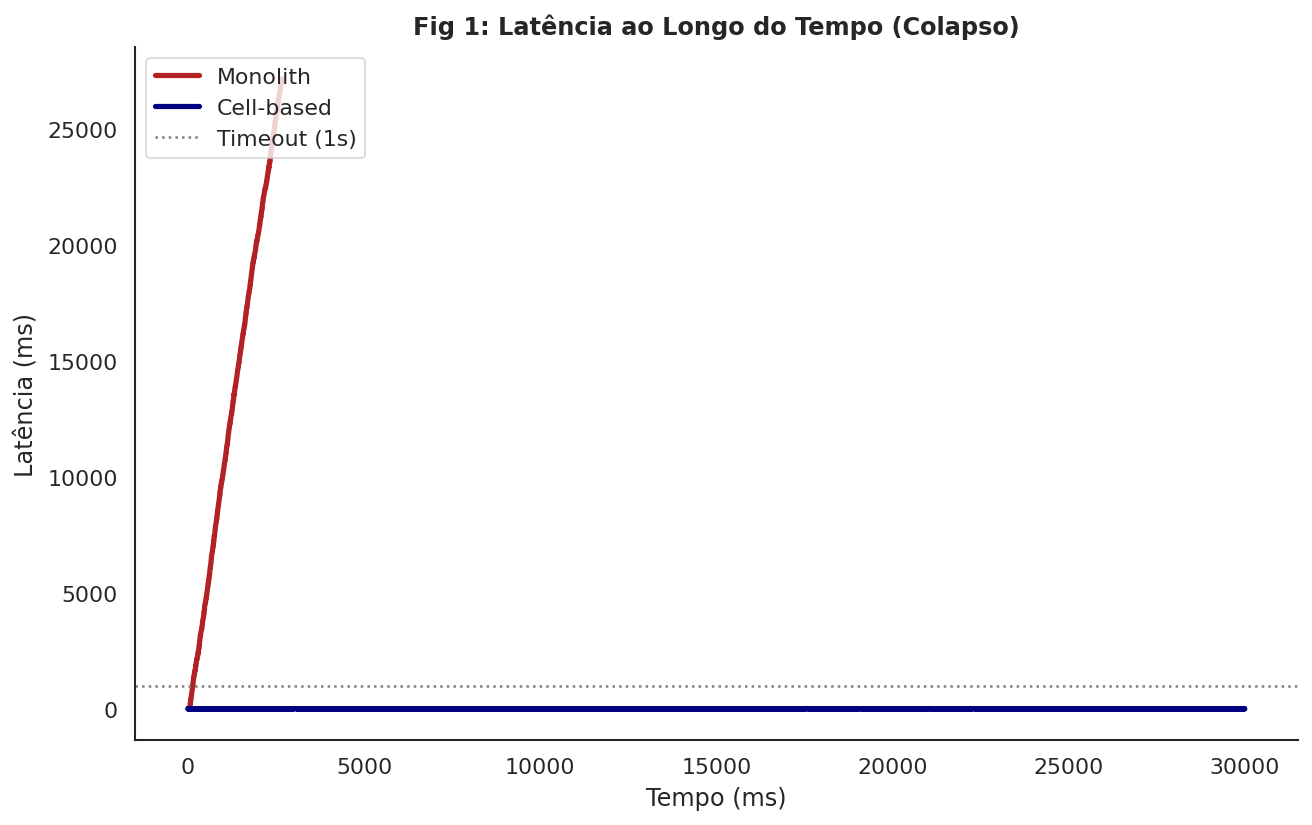

✨ Artefato Salvo: fig2_risk_kde.png


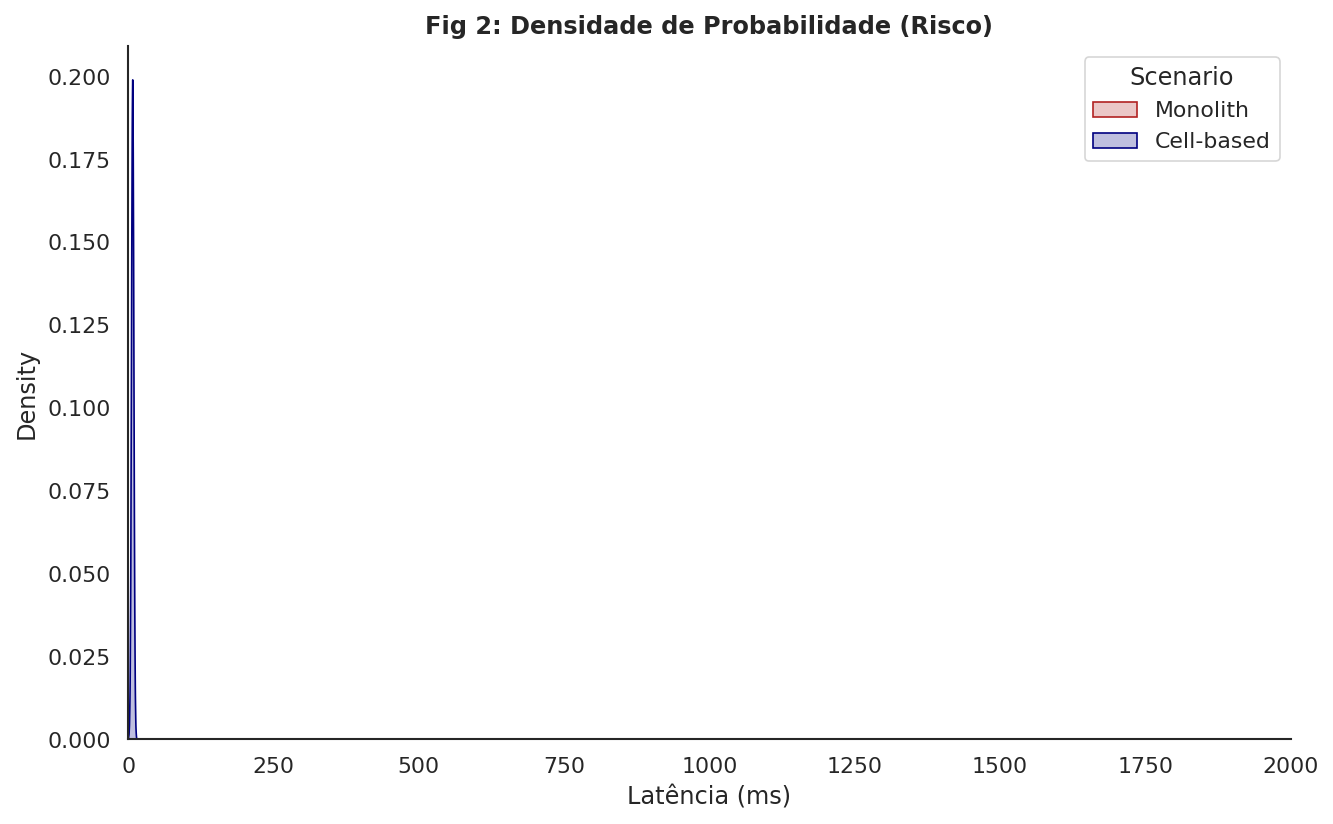

✨ Artefato Salvo: fig3_variance_box.png


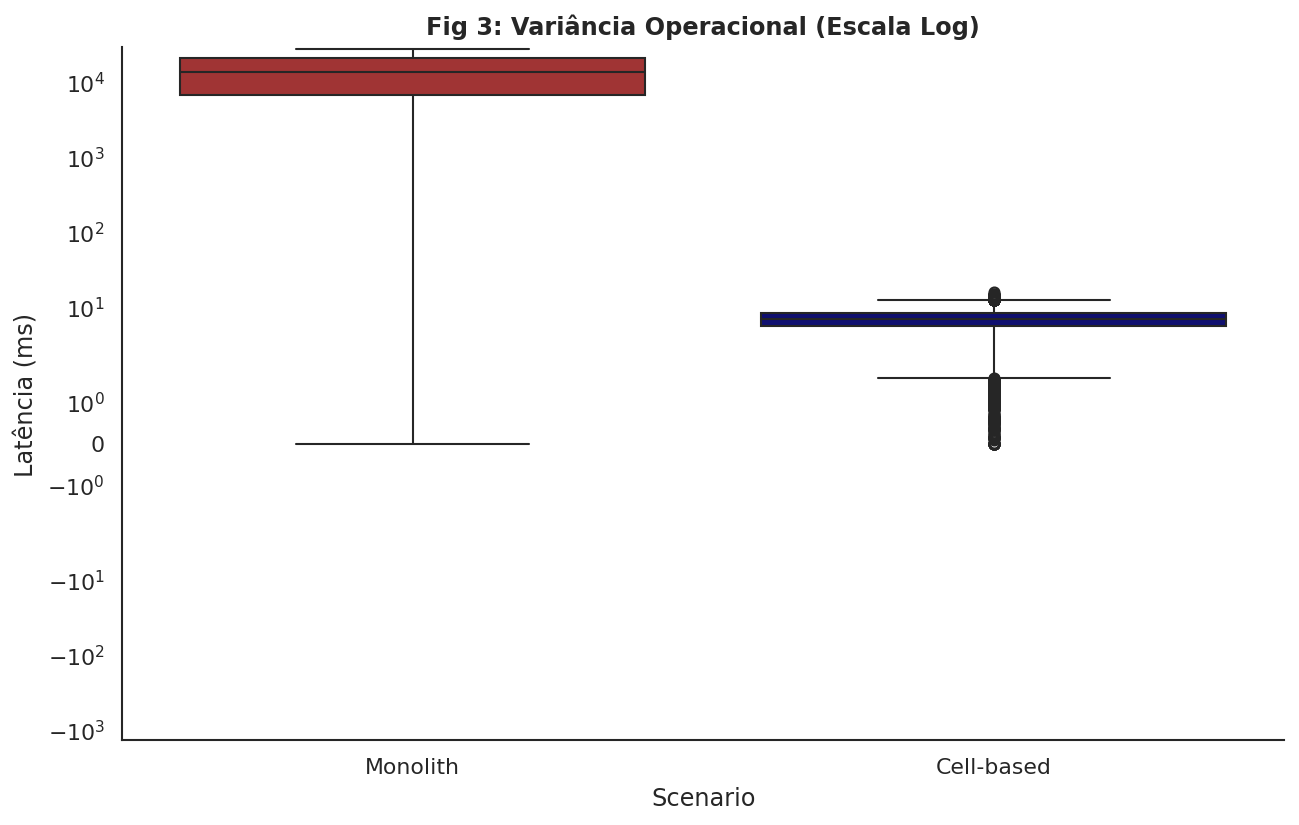

✨ Artefato Salvo: fig4_throughput.png


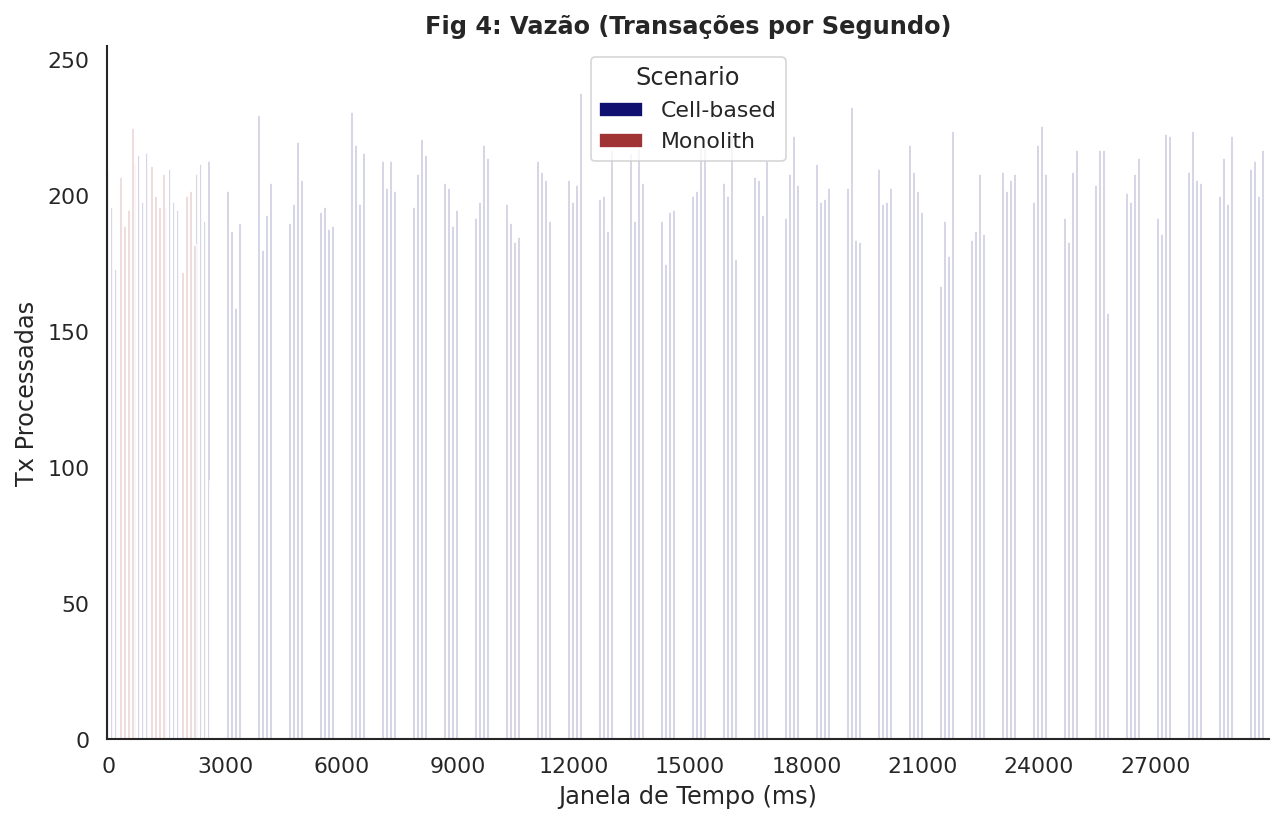

In [6]:
# ==============================================================================
# Visualization: four figures used in the manuscript (PNG, 300 dpi)
# ==============================================================================

# Global style tuned for paper figures.
sns.set_theme(style="white", context="paper", font_scale=1.2)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Fixed color mapping (consistent across figures and exports).
colors = {"Monolith": "#B22222", "Cell-based": "#000080"}

def save_plot(filename: str) -> None:
    # Save current matplotlib figure with reproducible export settings.
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Saved: {filename}")

# --- Fig 1. Time series (degradation / collapse) --------------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x="arrival_time",
    y="wait_time",
    hue="Scenario",
    palette=colors,
    linewidth=2.5,
)
plt.axhline(1000, color="gray", linestyle=":", label="Timeout (1s)")
plt.title("Fig 1: Latência ao Longo do Tempo (Colapso)", fontweight="bold")
plt.xlabel("Tempo (ms)")
plt.ylabel("Latência (ms)")
plt.legend(loc="upper left")
save_plot("fig1_latency_time.png")
plt.show()

# --- Fig 2. Tail-risk density (KDE) ---------------------------------------------
# We focus on the operationally relevant region (≤ 2000 ms) to make the contrast
# interpretable on a single axis.
df_risk = df[df["wait_time"] <= 2000].copy()

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df_risk,
    x="wait_time",
    hue="Scenario",
    fill=True,
    common_norm=False,
    palette=colors,
    alpha=0.35,
)
plt.title("Fig 2: Densidade de Probabilidade (Risco)", fontweight="bold")
plt.xlabel("Latência (ms)")
plt.ylabel("Density")
plt.xlim(0, 2000)
plt.legend(title="Scenario")
save_plot("fig2_risk_kde.png")
plt.show()

# --- Fig 3. Operational variance (boxplot, log scale) ---------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Scenario", y="wait_time", palette=colors)
plt.yscale("symlog", linthresh=1)  # stable near 0; log-like for large values
plt.title("Fig 3: Variância Operacional (Escala Log)", fontweight="bold")
plt.xlabel("Scenario")
plt.ylabel("Latência (ms)")
save_plot("fig3_variance_box.png")
plt.show()

# --- Fig 4. Throughput (Tx/s) ---------------------------------------------------
# Throughput is computed as transaction arrivals per aggregation window, then
# normalized to transactions/second.
throughput = df.groupby(["Scenario", "time_bin"]).size().reset_index(name="count")
throughput["tps"] = throughput["count"] * (1000.0 / THROUGHPUT_BIN_MS)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=throughput,
    x="time_bin",
    y="tps",
    hue="Scenario",
    palette=colors,
    linewidth=2.5,
)
plt.title("Fig 4: Vazão (Transações por Segundo)", fontweight="bold")
plt.xlabel("Janela de Tempo (ms)")
plt.ylabel("Tx/s")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.legend(title="Scenario")
save_plot("fig4_throughput.png")
plt.show()


## 7 &ensp; Provenance record

Dump the full experiment configuration as JSON for inclusion in
supplementary materials or data-repository metadata.


In [7]:
import json

provenance = {
    "analysis": {
        "throughput_bin_ms": THROUGHPUT_BIN_MS,
        "risk_kde_xlim_ms": 2000,
    },
    "experiment_a": cfg_monolith.to_dict(),
    "experiment_b": cfg_cells.to_dict(),
}

with open("experiment_provenance.json", "w") as fp:
    json.dump(provenance, fp, indent=2)

print(json.dumps(provenance, indent=2))


{
  "experiment_a": {
    "mode": "MONOLITH",
    "traffic_type": "STRESS",
    "random_seed": 42,
    "simulation_time": 30000,
    "arrival_rate_normal": 50,
    "arrival_rate_stress": 2000,
    "event_bus_ack_ms": 2.0,
    "num_cells": 10,
    "db_pool_capacity": 50,
    "cell_capacity": 10,
    "contention_queue_threshold": 20,
    "contention_penalty_factor": 5.0,
    "latency_log_mean_ms": 50.0,
    "latency_log_sigma": 0.5,
    "shard_id_upper_bound": 10000
  },
  "experiment_b": {
    "mode": "CELL_BASED",
    "traffic_type": "STRESS",
    "random_seed": 42,
    "simulation_time": 30000,
    "arrival_rate_normal": 50,
    "arrival_rate_stress": 2000,
    "event_bus_ack_ms": 2.0,
    "num_cells": 10,
    "db_pool_capacity": 50,
    "cell_capacity": 10,
    "contention_queue_threshold": 20,
    "contention_penalty_factor": 5.0,
    "latency_log_mean_ms": 50.0,
    "latency_log_sigma": 0.5,
    "shard_id_upper_bound": 10000
  }
}


## Notes for the manuscript

- Report both central tendency (median) and tail behavior (p95 / p99).  
- In `CELL_BASED`, `wait_time` represents the **ingress ACK**, not the full
  end-to-end commit latency. This is consistent with an asynchronous write-path
  where the client receives acknowledgement after broker enqueue (or equivalent
  durability boundary).  
- The ACK path is modeled as a compact mixture (micro-jitter + backlog sensitivity
  + rare tail spikes). All parameters are explicit in `ExperimentConfig` and are
  recorded in the provenance JSON to support auditability and sensitivity analysis.  
- The provenance JSON should accompany the Zenodo deposit to ensure complete
  computational reproducibility.
